# Slope Limiting
This page is based on section 6.3.4 of Krzysztof Fidkowski's CFD course notes.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors()


In this example we consider a generic, **linear, 3-point** scheme for the advection equation on a uniform 1D grid:

$$u_{j}^{n+1} = c_{-1}u_{j-1}^{n} + c_{0}u_{j}^{n} + c_{1}u_{j+1}^{n}$$

For consistency (the requirement that the discrete equation converges to the true PDE as $\Delta t, \Delta x \rightarrow 0$), we require:

$$c_{-1} + c_{0} + c_{1} = 1$$
$$-c_{-1} + c_{1} = -\sigma$$

Where $\sigma = \frac{a\Delta t}{\Delta x}$ is the CFL number. 
With 3 coefficients and 2 equations, we can choose one of the coefficients freely.
The update equation can be written as:

$$u_{j}^{n+1} = u_{j}^{n} - \frac{\sigma}{2} \left(u_{j+1}^{n} - u_{j-1}^{n}\right) + \frac{q}{2} \left(u_{j+1}^{n} - 2u_J^n + u_{j-1}^{n}\right)$$

However, the choice of $q$ is not totally free.
Using von-Neumann stability analysis it can be shown that this scheme is only stable when:

$$\sigma^2 \leq q \leq 1$$

It can also be shown that to be monotonicity preserving, we require:

$$|\sigma| \leq q \leq 1$$

Many of the fully discrete schemes for the advection equation that we covered earlier in the course can be written in this form:

- $q=0$: FTCS, unconditionally unstable since $q<\sigma^2$
- $q=|\sigma|$: First order upwind, stable and monotonicity preserving, but only first order accurate
- $q=1$: Lax-Friedrichs, stable and monotonicity preserving, but only first order accurate
- $q=\sigma^2$: Lax-Wendroff, stable, second order accurate, not monotonicity preserving

The code below plots the q-$\sigma$ curves for each of these schemes, along with the unstable and monotonicity preserving regions.

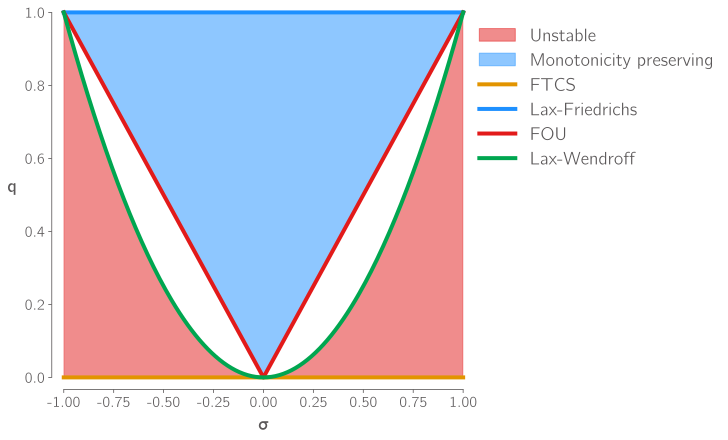

In [2]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$q$", rotation="horizontal", ha="right")

sigma = np.linspace(-1, 1, 201)
FTCS = np.zeros_like(sigma)
LaxFriedrichs = np.ones_like(sigma)
FOU = np.abs(sigma)
LaxWendroff = sigma**2
LPE = (1 + 2 * sigma**2) / 3

ax.fill_between(sigma, FTCS, LaxWendroff, color=colors["Red"], alpha=0.5, label="Unstable")
ax.fill_between(sigma, FOU, LaxFriedrichs, color=colors["Blue"], alpha=0.5, label="Monotonicity preserving")

for line, name in zip([FTCS, LaxFriedrichs, FOU, LaxWendroff], ["FTCS", "Lax-Friedrichs", "FOU", "Lax-Wendroff"]):
    ax.plot(sigma, line, clip_on=False, label=name, lw=4)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
niceplots.adjust_spines(ax)


As you can see, none of these schemes are stable, high-order accurate, and monotonicity preserving. 
Gudonov's theorem (see section 6.3.3 in the course notes) shows that it is impossible for a linear scheme to be all 3.
If we want a high-order accurate scheme that is also TVD, we need to use a nonlinear scheme, where the coefficients $c_{-1}, c_0, c_1$ depend on the solution values $u$.

For this nonlinear scheme, we'll start withe second order Lax-Wendroff scheme:

$$u_{j}^{n+1} = u_{j}^{n} - \frac{\sigma}{2} \left(u_{j+1}^{n} - u_{j-1}^{n}\right) - \frac{1}{2}\sigma \left(1-\sigma\right) \left(u_{j+1}^{n} - 2u_J^n + u_{j-1}^{n}\right)$$

This can be thought of as equivalent to the first order upwind scheme, with an added negative diffusion term.
This "anti-diffusion" term counteracts the artificial diffusion caused by the truncation error in FOU and makes the scheme second order accurate, but also what makes it non-TVD.
We'd therefore like to limit the amount of anti-diffusion, while still retaining second order accuracy.

To do this limiting, we need to consider the equivalent flux for the Lax-Wendroff scheme:

$$F^{LW}_{j+1/2} = au_j + \frac{a}{2}\left(1-\sigma\right)\left(u_{j+1} - u_j\right)$$

Now we introduce a flux limiter $\phi$, which limits the amount of anti-diffusion:

$$F^{LW}_{j+1/2} = au_j + \phi_{j+1/2}\frac{a}{2}\left(1-\sigma\right)\left(u_{j+1} - u_j\right)$$

Using this flux, the update equation becomes:

$$u_{j}^{n+1} = u_{j}^{n} - \frac{\sigma}{2} \left(u_{j+1}^{n} - u_{j-1}^{n}\right) - \frac{1}{2}\sigma \left(1-\sigma\right) \left[\phi_{j+1/2}\left(u_{j+1}^{n} - u_j^n\right) - \phi_{j-1/2}\left(u_{j-1}^{n} - u_j^n\right)\right]$$

With $\phi=1$ this is the non-TVD, second-order accurate, Lax-Wendroff scheme, and with $\phi=0$ it is the TVD,  first-order accurate, upwind scheme.

**We therefore want to choose an equation for $\phi$ that is as close to 1 as possible whilst satisfying the TVD requirements.**

It can be shown (see the course notes) that the TVD requirements are satisfied if:

$$\phi(r) = 0 \quad \text{for} \quad r \leq 0, \quad 0 \leq \frac{\phi(r)}{r} \leq 2, \quad 0 \leq \phi(r) \leq 2$$

Where $r$ is the ratio of the upwind and downwind gradients:

$$r = \frac{u_j - u_{j-1}}{u_{j+1} - u_j}$$

It can also be shown that the requirements for second-order accuracy are:

$$\phi(r) \geq r \quad \text{for} \quad 0 \leq r \leq 1, \quad \phi(1)=1, \quad \phi(r) \geq 1 \quad \text{for} \quad r \geq 1 $$

The code below creates a plot which shows the valid regions for $\phi(r)$ to be TVD and second-order accurate.

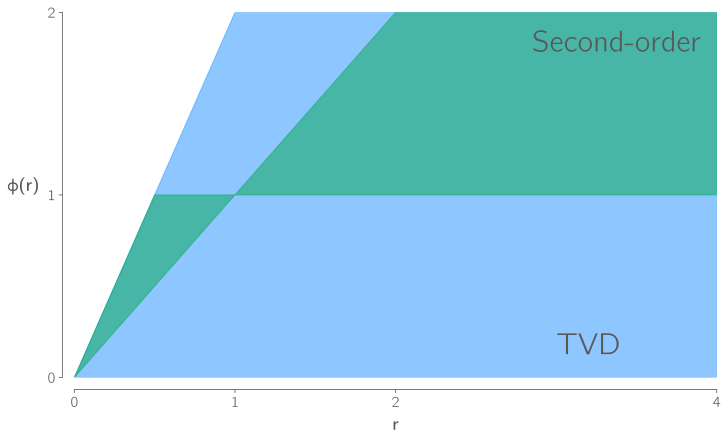

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\phi(r)$", rotation="horizontal", ha="right")

r = np.linspace(0, 4, 401)

TVDLowerBound = np.zeros_like(r)
TVDUpperBound = np.minimum(2, 2 * r)

highOrderLowerBound = np.minimum(1, r)
highOrderUpperBound = np.where(r < 1, np.minimum(2 * r, 1), np.minimum(2, r))

ax.fill_between(r, TVDLowerBound, TVDUpperBound, color=colors["Blue"], alpha=0.5, label="TVD")
ax.fill_between(r, highOrderLowerBound, highOrderUpperBound, color=colors["Green"], alpha=0.5, label="High order")
ax.annotate("TVD", xy=(3, 0.1), ha="left", va="bottom", fontsize=30)
ax.annotate("Second-order", xy=(3.9, 1.9), ha="right", va="top", fontsize=30)

ax.set_xticks([0, 1, 2, 4])
ax.set_yticks([0, 1, 2])
niceplots.adjust_spines(ax)


Now we plot three of the most common limiter curves on this plot, the equations for these limiters are given in the course notes:

- Minmod: Chooses the most diffusive value of $\phi$ that satisfies the TVD and second-order requirements
- Superbee: Chooses the least diffusive value of $\phi$ that satisfies the TVD and second-order requirements
- Van Leer: A smoothly varying limiter that satisfies the TVD and second-order requirements

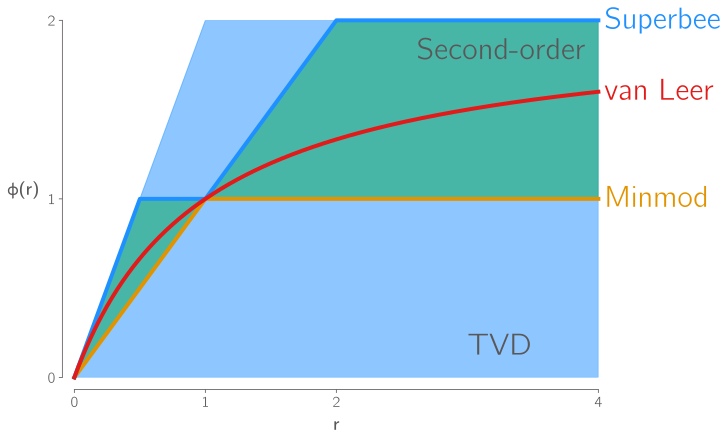

In [4]:
def minmod(r):
    return np.maximum(0, np.minimum(1, r))


def superbee(r):
    return np.maximum(np.maximum(0, np.minimum(2 * r, 1)), np.minimum(r, 2))


def vanLeer(r):
    return (r + np.abs(r)) / (1 + np.abs(r))


def FOU(r):
    return np.zeros_like(r)


def LaxWendroff(r):
    return np.ones_like(r)


ax.plot(r, minmod(r), label="Minmod", lw=4, clip_on=False)
ax.plot(r, superbee(r), label="Superbee", lw=4, clip_on=False)
ax.plot(r, vanLeer(r), label="van Leer", lw=4, clip_on=False)

niceplots.label_line_ends(ax, fontsize=30)
fig


## Slope-limiting demo

The code below tests first-order upwind and non-limited Lax-Wendroff against the Lax-Wendroff limited with the three limiters above.

The initial condition contains 4 different waves with different levels of smoothness. We test the limiters by simulating the linear advection equation for long enough that the waves should return to their original positions. Any differences between the initial and final states are therefore due to numerical errors in the schemes.

/tmp/ipykernel_18997/4273324961.py:30: RuntimeWarning: invalid value encountered in sqrt
  uHemi = np.sqrt(1 - (2 * (x - xMid) / L) ** 2)


Text(0.5, 1.0, 'Initial condition')

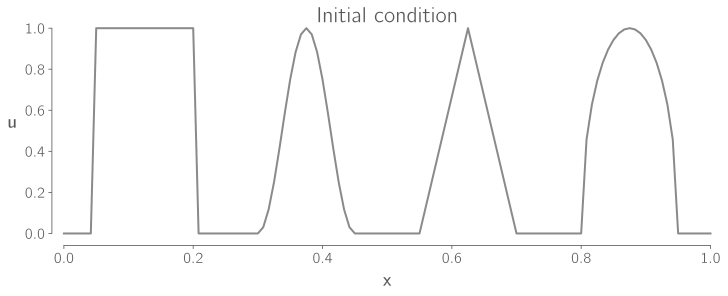

In [5]:
L = 1.0
N = 120
x = np.linspace(0, L, N + 1)
dx = L / N
u0 = np.zeros_like(x)

# Unit step
u0 = np.where(np.logical_and(x >= 0.05, x <= 0.2), 1, 0)

# Cosine
xStart = 0.3
xEnd = 0.45
L = xEnd - xStart
uCosine = 0.5 * (1 - np.cos(2 * np.pi * (x - xStart) / L))
u0 = np.where(np.logical_and(x >= xStart, x <= xEnd), uCosine, u0)

# linear spike
xStart = 0.55
xEnd = 0.7
xMid = (xStart + xEnd) / 2
L = xEnd - xStart
uSpike = 1 - 2 * np.abs(x - xMid) / L
# uSpike = np.exp(-50 * (np.abs(x - xMid) / L)**2)
u0 = np.where(np.logical_and(x >= xStart, x <= xEnd), uSpike, u0)

# hemisphere
xStart = 0.8
xEnd = 0.95
xMid = (xStart + xEnd) / 2
uHemi = np.sqrt(1 - (2 * (x - xMid) / L) ** 2)
u0 = np.where(np.logical_and(x >= xStart, x <= xEnd), uHemi, u0)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")
ax.plot(x, u0, label="Initial condition", c=colors["Axis"], alpha=0.7, clip_on=False)

niceplots.adjust_spines(ax)

ax.set_title("Initial condition")


/tmp/ipykernel_18997/3229122800.py:2: RuntimeWarning: divide by zero encountered in divide
  r = (u - uLeft) / (uRight - u)
/tmp/ipykernel_18997/3229122800.py:2: RuntimeWarning: invalid value encountered in divide
  r = (u - uLeft) / (uRight - u)


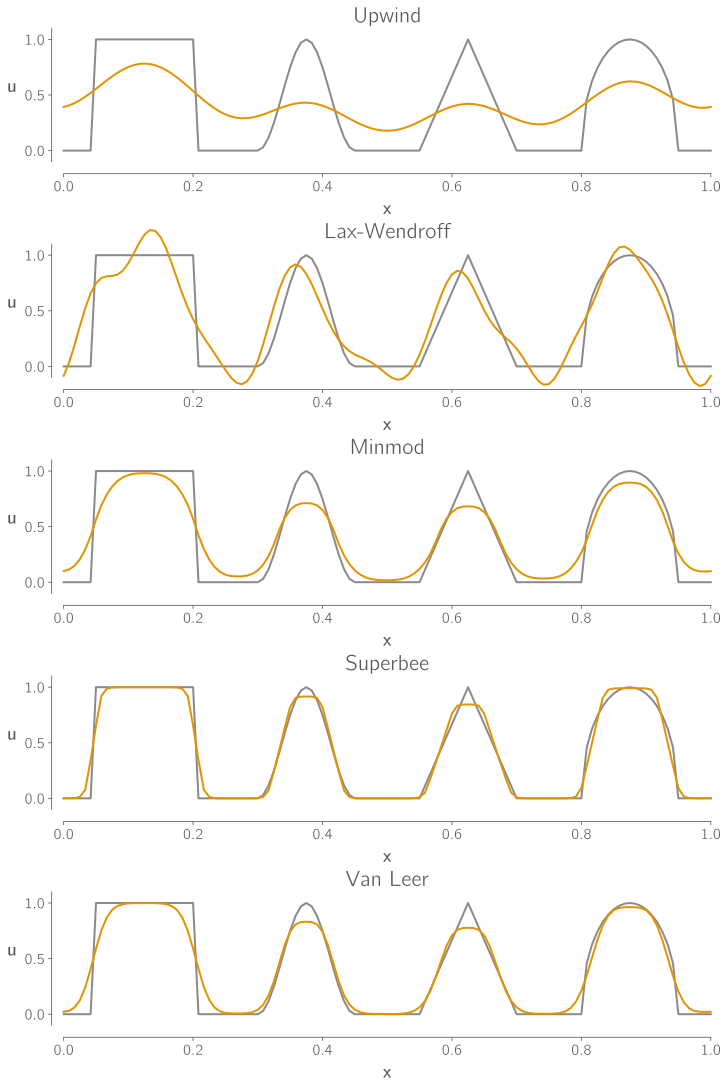

In [6]:
def computeR(u, uLeft, uRight):
    r = (u - uLeft) / (uRight - u)
    r = np.where(np.isnan(r), np.sign(u - uLeft) * 1e6, r)
    r = np.where(np.isinf(r), np.sign(u - uLeft) * 1e6, r)
    return r


def advect(u0, sigma, nPeriods, limiterFunc):
    u = u0.copy()[:-1]

    Nx = len(u)
    numTimeSteps = int(np.ceil(nPeriods * Nx / sigma))

    for _ in range(numTimeSteps):
        uLeftLeft = np.roll(u, 2)
        uLeft = np.roll(u, 1)
        uRight = np.roll(u, -1)
        rPlus = computeR(u, uLeft, uRight)
        rMinus = computeR(uLeft, uLeftLeft, u)

        u += -sigma * (u - uLeft) - 0.5 * sigma * (1 - sigma) * (
            limiterFunc(rPlus) * (uRight - u) - limiterFunc(rMinus) * (u - uLeft)
        )

    return np.append(u, u[0])


schemes = {
    "Upwind": FOU,
    "Lax-Wendroff": LaxWendroff,
    "Minmod": minmod,
    "Superbee": superbee,
    "Van Leer": vanLeer,
}

fig, axes = plt.subplots(nrows=len(schemes), figsize=(10, 3 * len(schemes)))

for ax, (name, scheme) in zip(axes, schemes.items()):
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")
    ax.plot(x, u0, label="Initial condition", c=colors["Axis"], alpha=0.7, clip_on=False)

    u = advect(u0, 0.5, 1, scheme)
    ax.plot(x, u, label=name, clip_on=False)
    ax.set_title(name)
    ax.set_ylim(-0.1, 1.1)

    niceplots.adjust_spines(ax)


Some observations from these results:
- First order upwind is overly diffusive, and smears out the waves
- Lax-Wendroff introduce unphysical oscilations, particularly near shocks
- Of the three limited schemes, minmod is the most diffusive.
- Superbee is the least diffusive, maintaining shocks well, but also seems to "over-sharpen" some of the smoother waves
- The Van Leer limiter is a good compromise between the two, maintaining shocks well, without much over-sharpening.